In [1]:
import numpy as np
def generate_real_samples(n):
    '''generate n real samples with class labels'''
    x1 = np.random.rand(n) - 0.5 #generate a random number between [-0.5,0.5]
    x2 = x1**3        #generate outputs
    x1 = x1.reshape(n, 1)
    x2 = x2.reshape(n, 1)
    X = np.hstack((x1, x2))   #stack layers
    y = np.ones((n, 1))     #generate class label
    return X,y

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.utils import plot_model
import matplotlib.pyplot as plt

def define_discriminator(inputs = 2):
    ''' function to return the compiled discriminator model'''
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer = 'he_uniform', input_dim = inputs))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(5, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 25)                75        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 25)                0         
                                                                 
 dense_8 (Dense)             (None, 15)                390       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 80        
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 5)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                

In [6]:
def define_generator(latent_dim, outputs = 2):
    model = Sequential()
    model.add(Dense(25, activation = 'relu', kernel_initializer= 'he_uniform', input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(outputs, activation = 'linear'))
    return model

In [7]:
latent_dim = 5
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 25)                150       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 25)                0         
                                                                 
 dense_12 (Dense)            (None, 15)                390       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 32        
                                                                 
Total params: 572
Trainable params: 572
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install

In [8]:
def generate_latent_points(latent_dim, n):
    '''generate points in latent space as input for the generator'''
    x_input = np.random.rand(latent_dim*n) #generate points in latent space
    x_input = x_input.reshape(n,latent_dim)  #reshape
    return x_input

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n) #genarate points in latent space
    x = generator.predict(x_input) #predict outputs
    y = np.zeros((n, 1))
    return x, y

4/4 [==============================] - 1s 5ms/step


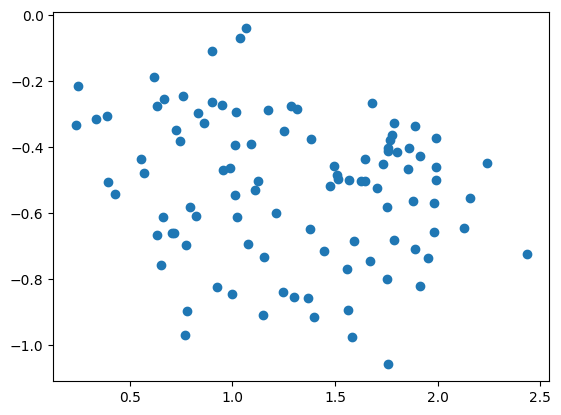

In [9]:
X, _ = generate_fake_samples(generator_model, latent_dim, 100)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [10]:
def define_gan(generator, discriminator):
    '''define the combined generator and discriminator model'''
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

In [11]:

gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 2)                 572       
                                                                 
 sequential_2 (Sequential)   (None, 1)                 551       
                                                                 
Total params: 1,123
Trainable params: 572
Non-trainable params: 551
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
def train_gan(g_model,d_model,gan_model,latent_dim, num_epochs = 10000, num_eval = 2000, batch_size = 128):
    ''' function to train gan model'''
    half_batch = int(batch_size/2)
  #run epochs
    for i in range(num_epochs):
        X_real, y_real = generate_real_samples(half_batch) #generate real examples
        d_model.train_on_batch(X_real, y_real)               # train on real data
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) #generate fake samples
        d_model.train_on_batch(X_fake, y_fake)                #train on fake data
        #prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))    #generate fake labels for gan
        gan_model.train_on_batch(x_gan, y_gan)
        if (i+1) % num_eval == 0:
            summarize_performance(i + 1, g_model, d_model, latent_dim)

In [13]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n = 100):
    '''evaluate the discriminator and plot real and fake samples'''
    x_real, y_real = generate_real_samples(n)      #generate real samples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose = 1)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 1)
    print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real) + ' Fake Acc.: '+ str(acc_fake))
    plt.scatter(x_real[:,0], x_real[:,1], color = 'red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')
    plt.show()

2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 8ms/step


2/2 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 1.0000
Epoch: 2000 Real Acc.: 0.3700000047683716 Fake Acc.: 1.0


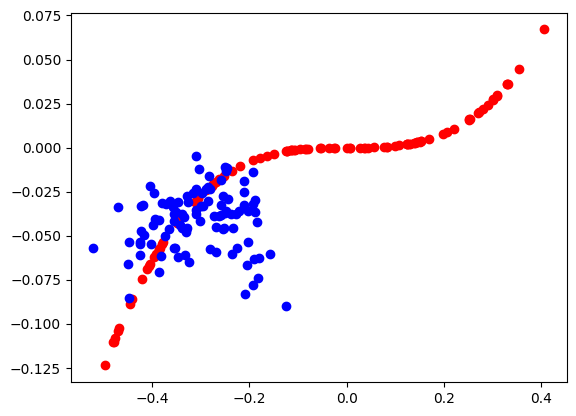

2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 6ms/step - loss: 0.9030 - accuracy: 0.4900
Epoch: 4000 Real Acc.: 0.33000001311302185 Fake Acc.: 0.49000000953674316


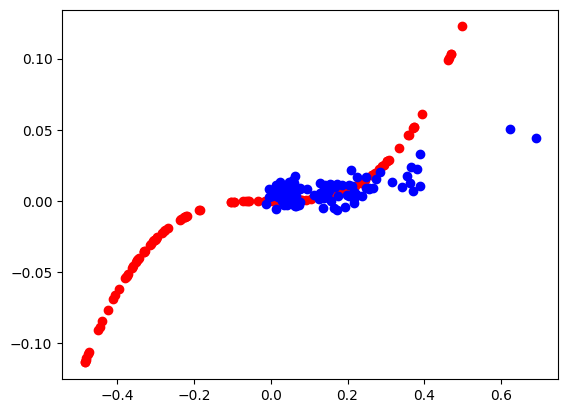

2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 6ms/step - loss: 0.6978 - accuracy: 0.4700
Epoch: 6000 Real Acc.: 0.25 Fake Acc.: 0.4699999988079071


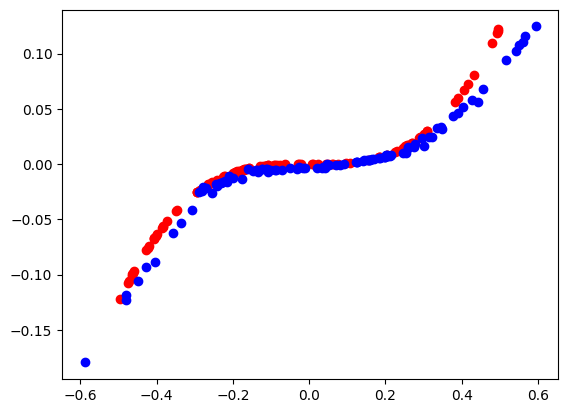

2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 7ms/step - loss: 0.4582 - accuracy: 1.0000
Epoch: 8000 Real Acc.: 0.8899999856948853 Fake Acc.: 1.0


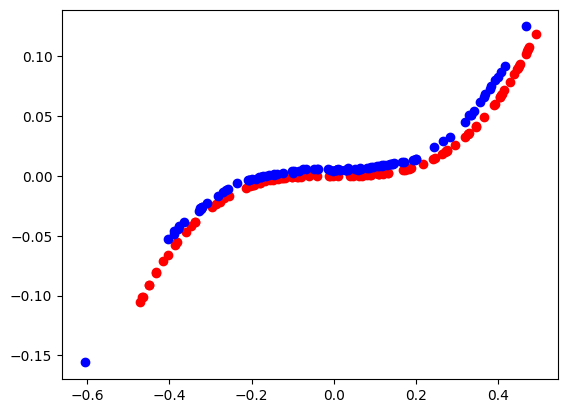

2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 6ms/step - loss: 0.8897 - accuracy: 0.3200
Epoch: 10000 Real Acc.: 0.46000000834465027 Fake Acc.: 0.3199999928474426


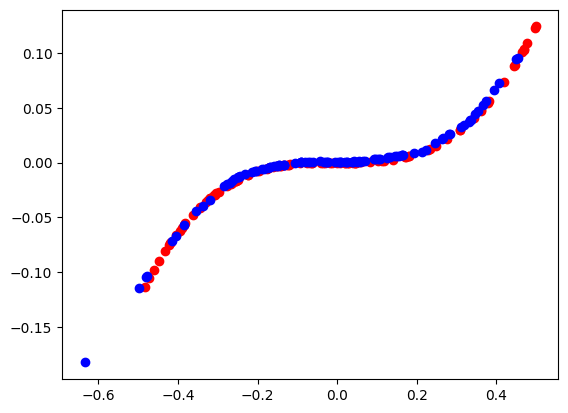

In [14]:
train_gan(generator_model, discriminator_model, gan_model, latent_dim)